# ULMFIT

%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import re
import statistics
import fastai
print('fast.ai version is:', fastai.__version__)

from fastai import *
from fastai.text import *
from sklearn.model_selection import train_test_split
path = ''

## Подготовим датасет

In [ ]:
df_train=pd.DataFrame(columns=['Text', 'Label'])
df_test=pd.DataFrame(columns=['Text', 'Label'])
df_val=pd.DataFrame(columns=['Text', 'Label'])


label_lst = sorted(data['label'].value_counts().index.to_list())
#decoder = dict(enumerate(label_lst))
encoder = dict((j, i) for i, j in enumerate(label_lst))

X, Y = data['text'], to_categorical(data['label'].replace(encoder))
df_train['Text'], df_test['Text'], df_train['Label'], df_test['Label'] = train_test_split(X, Y, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=1)

In [ ]:
df_train.groupby('Label').count()

,Text
Label,
0.0,1924
1.0,632


In [ ]:
df_val.groupby('Label').count()

,Text
Label,
0.0,483
1.0,157


In [ ]:
df_test.groupby('Label').count()

,Text
Label,
0.0,589
1.0,211


In [ ]:
tokenizer=Tokenizer(lang='xx')
data_lm = TextLMDataBunch.from_df(path, tokenizer=tokenizer, bs=16, train_df=df_train, valid_df=df_val, text_cols=0)

In [ ]:
data_lm.show_batch()

idx,text
0,"и права обычно происходит в контексте тех или иных методологических подходов , на которые часто оказывали влияние те или иные политические обстоятельства . xxmaj политический xxunk и теоретическая ориентация характерны в основном для немецкой историографии . \n xxmaj на всем протяжении xxup xix в . вплоть до первой половины xxup xx в . в на германскую историографию , следуя принципам xxup л. фон xxmaj ранке , преобладающее влияние оказывали"
1,"xxmaj берлин , 1865 ) и xxmaj xxunk ( xxmaj xxunk . , 1873 ) . xxmaj см . xxmaj xxunk , "" xxmaj xxunk xxmaj geschichte vom xxmaj xxunk der xxmaj xxunk xxunk zur xxmaj xxunk der xxmaj xxunk xxunk xxmaj xxunk "" ( т . 1 , xxmaj xxunk . , 1841 ) ; xxmaj xxunk , "" xxup a. , seine xxmaj xxunk una seine xxmaj xxunk"
2,"грузов и персонала xxup сша в xxmaj афганистан , xxunk с новой американской администрацией в июле , в дополнение к уже действующим аналогичным договоренностям с xxmaj германией и xxmaj францией означает , что в данном конкретном вопросе мы взяли на себя по сути дела xxunk обязательства перед американской стороной . xxmaj однако возникает вопрос о том , в какой мере наши новые союзники в деле борьбы с международным \n"
3,"и , xxunk и развиваясь , просуществовала , как самостоятельная и архитектурная форма , вплоть до появления стиля xxmaj возрождения . xxmaj литература : xxup м. xxmaj xxunk xxmaj xxunk , "" xxmaj de xxunk "" ( libri xxunk , xxmaj лейпциг , 1836 ) ; xxup l. xxup b. xxunk , "" xxmaj de re xxunk "" ( xxmaj флоренция , 1845 ) ; xxmaj xxunk xxmaj xxunk """
4,"- лицо , руки , платье , фон - привлекает художника в равной мере . xxmaj кисть легко и бездумно скользит по xxunk » [ 3 , с . 123]. « xxmaj xxunk xxunk \n той » мастера салонно - академического направления в своих работах успешно сочетали форму большого xxunk xxunk портрета , xxunk от академической школы и влияния xxunk портретов второй четверти xxup xix в . , с"


# Загрузим предобученный ULMFit

https://github.com/mamamot/Russian-ULMFit
 Нужно загрузить два файла представленных ниже и положить в папку рядом с блокнотом
 1. lm_5_ep_lr2-3_5_stlr.pth https://drive.google.com/open?id=1YgkuKWRgOsb3QkSFCWa2d089DBAhJOOV
 2. itos.pkl https://drive.google.com/open?id=1JbVfC6YRl-Ul28XkR5-Uj3nG_zOVSux_

In [ ]:
weights_pretrained = 'lm_5_ep_lr2-3_5_stlr'
itos_pretrained = 'itos'
pretained_data = (weights_pretrained, itos_pretrained)

# Находим оптимальный learning rate и обучаем пресказательную модель

In [ ]:
config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=pretained_data, drop_mult=0.3)
learn_lm.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


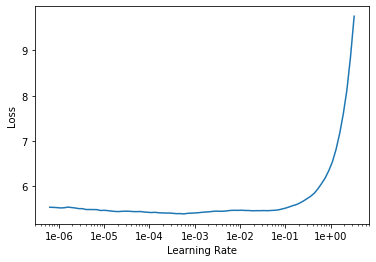

In [ ]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [ ]:
learn_lm.fit_one_cycle(3, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.749871,4.456943,0.322405,14:53
1,4.331776,4.217001,0.347473,14:55
2,3.953783,4.123746,0.358534,14:54


In [ ]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.664190,3.987026,0.368331,16:45
1,3.826320,3.973168,0.375428,16:44
2,3.444614,3.947513,0.379829,16:43
3,3.325252,3.957536,0.379454,16:43
4,3.177037,3.980526,0.378830,16:40


In [ ]:
learn_lm.save('lm_ft')

In [ ]:
learn_lm.predict("А куда же", n_words=5)

'А куда же год назад он муль -'

# Обучаем классификатор с сохраненным энкодером

In [ ]:
learn_lm.save_encoder('ft_enc')

In [ ]:
data_clas = TextClasDataBunch.from_df(path, vocab=data_lm.train_ds.vocab, bs=32, train_df=df_train, valid_df=df_val, text_cols=0, label_cols=1, tokenizer=tokenizer)

In [ ]:
data_clas.show_batch()

text,target
"xxbos в статье освещены закономерности в сфере семантических xxunk и происхождение таких разрядов слов , как прилагательные , отрицательные частицы , местоимения и xxunk в селькупском языке . xxmaj исследование базируется на именах мифических предков , почитаемых представителями селькупского этноса . xxmaj морфемное членение лексем позволяет восстановить их возможное исходное значение . xxmaj xxunk имен мифических предков породило процесс xxunk . \n в xxunk сообществах считалось , что тот",1.0
"xxbos xxmaj под классическим xxunk понимается то xxunk идейно - художественное направление в мусульманской литературе , прежде всего персоязычной поэзии , служившей главной моделью для афганской письменности , которое сложилось в период xxup хш — xxup ху вв . и характеризовалось следующими xxunk чертами . xxmaj во - первых , идейные основы этого направления xxunk исключительно на религиозной философии и эстетике , где xxunk тенденции после монгольского нашествия развивались в",1.0
"xxbos в поэме xxmaj гомера « xxmaj одиссея » спутники царя острова xxmaj xxunk попадают в страну , жители которой питаются xxunk . xxmaj гомер называет их xxmaj xxunk — букв . ' xxunk ' , вторая часть этого xxunk представляет собой основу xxunk от глагола xxunk — ' xxunk ' . xxmaj это племя живет на xxmaj xxunk побережье xxmaj африки . xxmaj попробуем идентифицировать их пищу . xxmaj",1.0
"xxbos xxmaj дается xxunk анализ роли этических идей в xxunk позднего xxmaj просвещения . xxmaj этический компонент текста « xxmaj истории государства xxmaj российского » xxup н. xxup м. xxmaj карамзина рассматривается в контексте англо - шотландской историографической традиции второй половины xxup xviii в . \n xxmaj xxunk интерес к проблемам добра и зла , тщательно xxunk диалоги с современниками о нравственном и xxunk в прошлом и настоящем -",1.0
"xxbos xxmaj существует утверждение , что все науки можно разделить на компьютерные и xxunk ( xxunk science ) . xxmaj xxunk науки - науки , в которых не изучаются вопросы , связанные с компьютерными дисциплинами . xxmaj тенденция такова , что число xxunk наук растет значительно медленнее , чем компьютерных . \n xxmaj часто говорят о xxunk ( xxunk ) , подразумевая при этом , что она отличается от",1.0


In [ ]:
config = awd_lstm_clas_config.copy()
config['n_hid'] = 1150
learn = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5)

In [ ]:
learn.load_encoder('ft_enc')
learn.freeze()

epoch,train_loss,valid_loss,time
0,0.597157,#na#,02:44


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


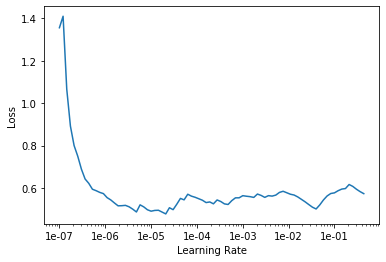

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

In [ ]:
learn.fit_one_cycle(2, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.239413,0.149111,03:34
1,0.183146,0.086540,03:34


In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.198836,0.087991,03:42
1,0.183157,0.048232,03:40
2,0.175382,0.066680,04:05


In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.169776,0.043567,05:17
1,0.162539,0.052661,05:01


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.164114,0.022871,06:46
1,0.144630,0.011132,06:31


In [ ]:
learn.save('test-0801')

In [ ]:
learn.predict('Дальше надо объяснять почему все что вы сделали — чушь?')

(FloatItem [0.097104], tensor([0.0971]), tensor([0.0971]))

# Проверка и метрики

In [ ]:
data_test_clas = TextClasDataBunch.from_df(path, vocab=data_lm.train_ds.vocab, bs=32, train_df=df_train, valid_df=df_test, text_cols=0, label_cols=1, tokenizer=tokenizer)

In [ ]:
config = awd_lstm_clas_config.copy()
config['n_hid'] = 1150
learn_test = text_classifier_learner(data_test_clas, AWD_LSTM, config=config, drop_mult=0.5)

In [ ]:
learn_test.load_encoder('ft_enc')
learn_test.load('test-0801')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (2556 items)
x: TextList
xxbos xxup xxunk xxup становления и xxup развития xxup средневековой xxup германской xxup государственности и xxup права в xxup контексте xxup отечественной и xxup немецкой xxup историографии 
  xxmaj проблема образования государства в ранней средневековой истории xxmaj германии , равно как и возникновение немецкой правовой традиции , представляет актуальность , как для отечественной xxunk , так и германской историографии вплоть до xxunk . xxmaj причем рассмотрение вопросов становления германской государственности и права обычно происходит в контексте тех или иных методологических подходов , на которые часто оказывали влияние те или иные политические обстоятельства . xxmaj политический xxunk и теоретическая ориентация характерны в основном для немецкой историографии . 
  xxmaj на всем протяжении xxup xix в . вплоть до первой половины xxup xx в . в на германскую историографию , следуя принципам xxup л. фон xxm

In [ ]:
learn_test.validate()

[0.010036545]

# Метрики

In [ ]:
neg_precision = interp.confusion_matrix()[0][0] / (interp.confusion_matrix()[0][0] + interp.confusion_matrix()[1][0])
neg_recall = interp.confusion_matrix()[0][0] / (interp.confusion_matrix()[0][0] + interp.confusion_matrix()[0][1])
pos_precision = interp.confusion_matrix()[1][1] / (interp.confusion_matrix()[1][1] + interp.confusion_matrix()[0][1])
pos_recall = interp.confusion_matrix()[1][1] / (interp.confusion_matrix()[1][1] + interp.confusion_matrix()[1][0])
neg_f1score = 2 * (neg_precision * neg_recall) / (neg_precision + neg_recall)
pos_f1score = 2 * (pos_precision * pos_recall) / (pos_precision + pos_recall)

IndexError: ignored

In [ ]:
print('Метка класса   Точность   Полнота   F1-score')
print('    Negative   {0:1.5f}    {1:1.5f}   {2:1.5f}'.format(neg_precision, neg_recall, neg_f1score))
print('    Positive   {0:1.5f}    {1:1.5f}   {2:1.5f}'.format(pos_precision, pos_recall, pos_f1score))
print('    Average    {0:1.5f}    {1:1.5f}   {2:1.5f}'.format(statistics.mean([neg_precision, pos_precision]), 
                                                              statistics.mean([neg_recall, pos_recall]), 
                                                              statistics.mean([neg_f1score, pos_f1score])))

Метка класса   Точность   Полнота   F1-score


NameError: ignored